In [8]:
import torch
from PIL import Image
import numpy as np
import pandas as pd
import torch
import os
import sys
from torch.utils import data
from sklearn.metrics import confusion_matrix as cm
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm

sys.path.append('../')

from utils import utils, model_fetch, dataloader, calibration_utils
metrics_dict = {}

%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:
# Loading both test sets - CIFAR and CIFAR - 10H -- Images are same.

def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

# CIFAR Data
file_path = '../data/data-cifar-10/cifar-10-batches-py/test_batch'
label_dict = unpickle(file_path)
cifar_labels = label_dict[b'labels'] 

# Create PyTorch dataset for CIFAR images

data = label_dict[b'data'].reshape((10000, 3, 32, 32))
data= data.transpose((0,2,3,1))
dataset = dataloader.MyDataset(data, cifar_labels)

In [10]:
# Which model to evaluate


####### Change This #######
model_of_interest = "augmented_teacher"
###########################
_CLASSES = ['plane', 'car', 'bird', 'cat',
            'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

base_path = '../distillation_experiments/runs/'

MODEL_DIRS = {
    "baseline_teacher": base_path + 'resnet18_baseline_retrained_1586751743/model_best.pth.tar',
    "mixup_teacher": base_path + 'resnet18_mixup_retrained_1586457991/checkpoint.pth.tar',
    "cutout_teacher": base_path + 'resnet18-cutout-restart-again_1586956477/model_best.pth.tar',
    "cutmix_teacher": base_path + 'resnet18_cutmix_retrained_1587147326-20200423T211700Z-001/model_best.pth.tar',
    "augmented_teacher": base_path + 'resnet18_augmented_retrained_1586751381/checkpoint.pth.tar',
    
    "baseline": base_path + 'student_baseline_retrained_temp20_gamma0.5_1587170761/checkpoint.pth.tar', 
    "mixup" : base_path + 'student_mixup_retrained_temp20_gamma0.5_1587170205/model_best.pth.tar',
    "cutout": base_path + 'lenet-student-cutout_1587345858/model_best.pth.tar',
    "cutmix": base_path + 'student_cutmix_temp20_gamma0.5_1587176582/model_best.pth.tar',
    "augmented": base_path + 'lenet-student-augmented-lr1e-4_1587576542/model_best.pth.tar'
}


In [65]:
model_list = ["baseline_teacher", "mixup_teacher", "cutmix_teacher", "augmented_teacher", "cutout_teacher"]
# model_list = ["baseline", "mixup", "cutmix", "augmented", "cutout"]

elem_list = []

for i, model_name in enumerate(model_list):
    if 'teacher' in model_name:
        model = model_fetch.fetch_student('resnet18')
    else:
        model = model_fetch.fetch_student('lenet')

    _, _ = utils.load_checkpoint(model, resume_filename=MODEL_DIRS[model_name])
    model = model.eval()
    preds_path =  '../../results/preds/' + model_name + '.npy'
    preds = np.load(preds_path)
    # True Labels
    y_true = np.array(cifar_labels)

    # Predicted y
    y_preds = np.argmax(preds, axis=1)
    y_confs = np.max(preds, axis=1)
    elem = calibration_utils.CalibrationError(y_confs, y_preds, y_true)
    elem_list.append(elem)

=> Loading Checkpoint '../distillation_experiments/runs/resnet18_baseline_retrained_1586751743/model_best.pth.tar'
Loaded checkpoint '../distillation_experiments/runs/resnet18_baseline_retrained_1586751743/model_best.pth.tar' (epoch 205)
Current Loss :  0.5587392343750482
=> Loading Checkpoint '../distillation_experiments/runs/resnet18_mixup_retrained_1586457991/checkpoint.pth.tar'
Loaded checkpoint '../distillation_experiments/runs/resnet18_mixup_retrained_1586457991/checkpoint.pth.tar' (epoch 216)
Current Loss :  0.46559315127662465
=> Loading Checkpoint '../distillation_experiments/runs/resnet18_cutmix_retrained_1587147326-20200423T211700Z-001/model_best.pth.tar'
Loaded checkpoint '../distillation_experiments/runs/resnet18_cutmix_retrained_1587147326-20200423T211700Z-001/model_best.pth.tar' (epoch 150)
Current Loss :  0.15525765070998215
=> Loading Checkpoint '../distillation_experiments/runs/resnet18_augmented_retrained_1586751381/checkpoint.pth.tar'
Loaded checkpoint '../distillat

In [47]:
plt.style.use("seaborn")

Text(0, 0.5, 'Accuracy')

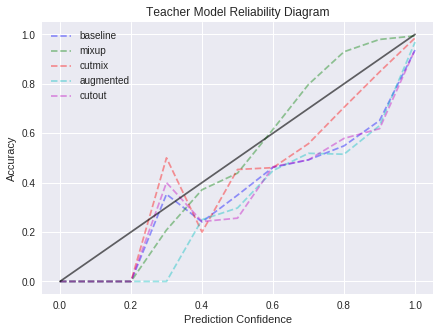

In [66]:
plt.figure(figsize=(7,5))
bline_x = bline_y = np.arange(0,1.1,0.1)
color_list = ['b', 'g', 'r', 'c', 'm']
alpha = 0.4
for i, elem in enumerate(elem_list):
    plt.plot(elem["Thresholds"], elem["Accuracies"], 
             c=color_list[i], alpha=alpha, label = model_list[i].split("_")[0] , 
             linestyle='dashed')
    
plt.plot(bline_x, bline_y, 'k', alpha=0.6)
plt.grid(True)
plt.legend()
if 'teacher' in model_name:
    plt.title("Teacher Model Reliability Diagram")
else:
    plt.title("Student Model Reliability Diagram")
    
plt.xlabel("Prediction Confidence")
plt.ylabel("Accuracy")

In [52]:
CE_df = {
    "MCE": {},
    "ECE": {}
}
for i, model_name in enumerate(model_list):
    CE_df["ECE"][model_name] = elem_list[i]["ECE"]
    CE_df["MCE"][model_name] = elem_list[i]["MCE"]
    
CE_df = pd.DataFrame(CE_df)
CE_df

,MCE,ECE
baseline,0.145870,0.096235
mixup,0.032865,0.020709
cutmix,0.028097,0.015719
augmented,0.069758,0.039545
cutout,0.108279,0.073156


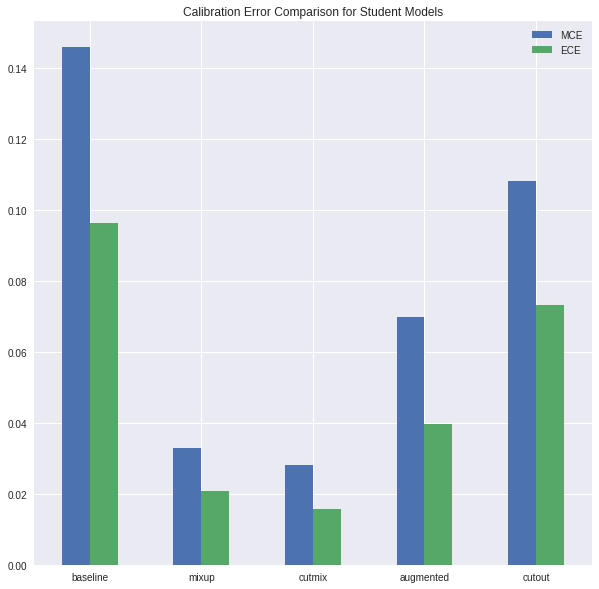

In [53]:
CE_df.plot(rot=0, kind='bar', figsize=(10,10), grid=True)
if "teacher" in model_name:
    plt.title("Calibration Error Comparison for Teacher Models")
else:
    plt.title("Calibration Error Comparison for Student Models")